In [1]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq, fftshift
from scipy.optimize import curve_fit
from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

[INFO][corrections] Numba not available, reverting to Numpy


In [20]:
#scan_name ="timesan_monoFEL_7122eV_12.7uJ_140_142mm_a"
scan_name ="Febpy_timescan_7123eV_150mJ_013"
#scan_name = 'Fluence_scan_7122.5eV_1ps_001'
#scan_name ="CytC_Fe2_7122eV_delayscan_002"


DIR = "/sf/alvra/data/p17589/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17589/res/scan_info/"

!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.7T
-rw-r--r--.   1 17589 p17589  18G Jul  8 01:27 Febpy_timescan_7123eV_150mJ_013_step0000.JF02T09V02.h5
-rw-r--r--.   1 17589 p17589 7.9G Jul  8 01:27 Febpy_timescan_7123eV_150mJ_013_step0000.JF06T04V01.h5
-rw-r--r--.   1 root  p17589 124K Jul  8 01:28 Febpy_timescan_7123eV_150mJ_013_step0000.BSREAD_CA.h5
-rw-r--r--.   1 17589 p17589  18G Jul  8 01:28 Febpy_timescan_7123eV_150mJ_013_step0001.JF02T09V02.h5
-rw-r--r--.   1 17589 p17589 7.9G Jul  8 01:28 Febpy_timescan_7123eV_150mJ_013_step0001.JF06T04V01.h5
-rw-r--r--.   1 root  p17589 326M Jul  8 01:29 Febpy_timescan_7123eV_150mJ_013_step0000.BSREAD.h5
-rw-r--r--.   1 root  p17589 128K Jul  8 01:29 Febpy_timescan_7123eV_150mJ_013_step0001.BSREAD_CA.h5
-rw-r--r--.   1 17589 p17589  18G Jul  8 01:29 Febpy_timescan_7123eV_150mJ_013_step0002.JF02T09V02.h5
-rw-r--r--.   1 17589 p17589 7.9G Jul  8 01:29 Febpy_timescan_7123eV_150mJ_013_step0002.JF06T04V01.h5
-rw-r--r--.   1 root  p17589 326M Jul  8 01:29 Febpy_timescan_7123eV_150mJ_01

ra-c-014.psi.ch
There are 255 files in the folder /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/


# Load one step and filter some data from I0

In [19]:
#f ="timesan_monoFEL_7122eV_12.7uJ_140_142mm_a_step0000.BSREAD.h5"
f ="Febpy_timescan_7123eV_150mJ_012_step0003.BSREAD.h5"


fn = DIR + f

(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
 DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(fn, channel_delay)

IzeroFEL_pump_original = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_original = IzeroFEL_unpump_shot.copy()
print (IzeroFEL_pump_original.shape, IzeroFEL_unpump_original.shape)
print (np.median(IzeroFEL_pump_shot))# - 1.2*(np.std(IzeroFEL_pump_shot)))

conditionPumpMax = IzeroFEL_pump_shot < np.median(IzeroFEL_pump_shot)+4*(np.std(IzeroFEL_pump_shot))
conditionPumpMin = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-4*(np.std(IzeroFEL_pump_shot))

conditionUnPumpMax = IzeroFEL_unpump_shot < np.median(IzeroFEL_unpump_shot)+4*(np.std(IzeroFEL_unpump_shot))
conditionUnPumpMin = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-4*(np.std(IzeroFEL_unpump_shot))

conditionGeneral = IzeroFEL_pump_shot > 0
conditionGeneral2 = IzeroFEL_unpump_shot > 0

IzeroFEL_pump_shot = IzeroFEL_pump_shot[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]

#Izero_pump_loop = [x for x in Izero_unpump_loop if (np.abs(x) > 1000)]

IzeroFEL_pump_shot = np.asarray(IzeroFEL_pump_shot)
IzeroFEL_pump_original = np.asarray(IzeroFEL_pump_original)



(1000, 1) (1000, 1)
0.018373072147369385


<IPython.core.display.Javascript object>


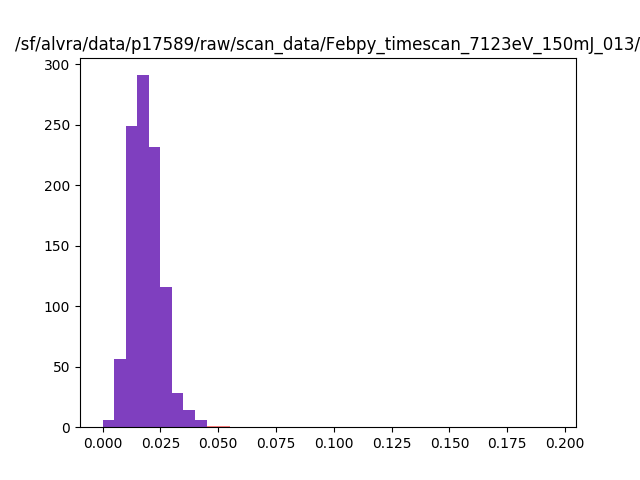

1000 998


In [218]:
#num_bins = 100
plt.figure()
plt.hist(IzeroFEL_pump_original, bins =np.arange(0,0.2,0.005), facecolor='red', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.2,0.005), facecolor='blue', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

plt.title(DIR)
plt.show()
print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

# Load time scan

In [21]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 51

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

DataTrans_pump = []
DataTrans_unpump = []
err_DataTrans_pump = []
err_DataTrans_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []


# from itertools import chain
# concatenated = chain(range(0,37), range(43, 50))
# for i in concatenated:
for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists:#  and i!=10:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(filename, channel_delay)
        
        threshold_pump = IzeroFEL_pump_shot > 0.01
        threshold_unpump = IzeroFEL_unpump_shot > 0.01
        condition_pump = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-2*(np.std(IzeroFEL_pump_shot))
        condition_unpump = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-2*(np.std(IzeroFEL_unpump_shot))

        DataFluo_pump_shot = DataFluo_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_pump_shot = IzeroFEL_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_pump_shot = DataTrans_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
              
        DataFluo_unpump_shot = DataFluo_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_unpump_shot = DataTrans_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
    
    
              
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        DataTrans_pump_shot_norm = DataTrans_pump_shot / IzeroFEL_pump_shot
        DataTrans_unpump_shot_norm = DataTrans_unpump_shot / IzeroFEL_unpump_shot
              
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        DataFluo_pump.append(DataFluo_pump_shot_norm.mean())
        DataFluo_unpump.append(DataFluo_unpump_shot_norm.mean())
        DataTrans_pump.append(DataTrans_pump_shot_norm.mean())
        DataTrans_unpump.append(DataTrans_unpump_shot_norm.mean())
        
        Pump_probe.append(Pump_probe_shot.mean())
        
        err_DataFluo_pump.append(DataFluo_pump_shot_norm.std()/np.sqrt(DataFluo_pump_shot_norm.size))
        err_DataFluo_unpump.append(DataFluo_unpump_shot_norm.std()/np.sqrt(DataFluo_unpump_shot_norm.size))
        err_DataTrans_pump.append(DataTrans_pump_shot_norm.std()/np.sqrt(DataTrans_pump_shot_norm.size))
        err_DataTrans_unpump.append(DataTrans_unpump_shot_norm.std()/np.sqrt(DataTrans_unpump_shot_norm.size))
              
        err_Pump_probe.append(Pump_probe_shot.std()/np.sqrt(Pump_probe_shot.size))
               
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.mean(Delay_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
DataTrans_pump = np.asarray(DataTrans_pump)
DataTrans_unpump = np.asarray(DataTrans_unpump)
              
Pump_probe = np.asarray(Pump_probe)
err_Pump_probe = np.asarray(err_Pump_probe)
              
err_DataFluo_pump = np.asarray(err_DataFluo_pump)
err_DataFluo_unpump = np.asarray(err_DataFluo_unpump)
err_DataTrans_pump = np.asarray(err_DataTrans_pump)
err_DataTrans_unpump = np.asarray(err_DataTrans_unpump)
            
Delay_mm = np.asarray(Delay_mm)

print ("Job done!")


/sf/alvra/data/p17589/res/scan_info/Febpy_timescan_7123eV_150mJ_013_scan_info.json
Processing 64 files
step 1 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0000.BSREAD.h5
step 2 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0001.BSREAD.h5
step 3 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0002.BSREAD.h5
step 4 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0003.BSREAD.h5
step 5 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0004.BSREAD.h5
step 6 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0005.BSREAD.h5
step 7 of 64 : Processing /

step 57 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0056.BSREAD.h5
step 58 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0057.BSREAD.h5
step 59 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0058.BSREAD.h5
step 60 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0059.BSREAD.h5
step 61 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0060.BSREAD.h5
step 62 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_013_step0061.BSREAD.h5
step 63 of 64 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_timescan_7123eV_150mJ_013/Febpy_timescan_7123eV_150mJ_0

# Plot time scans

<IPython.core.display.Javascript object>


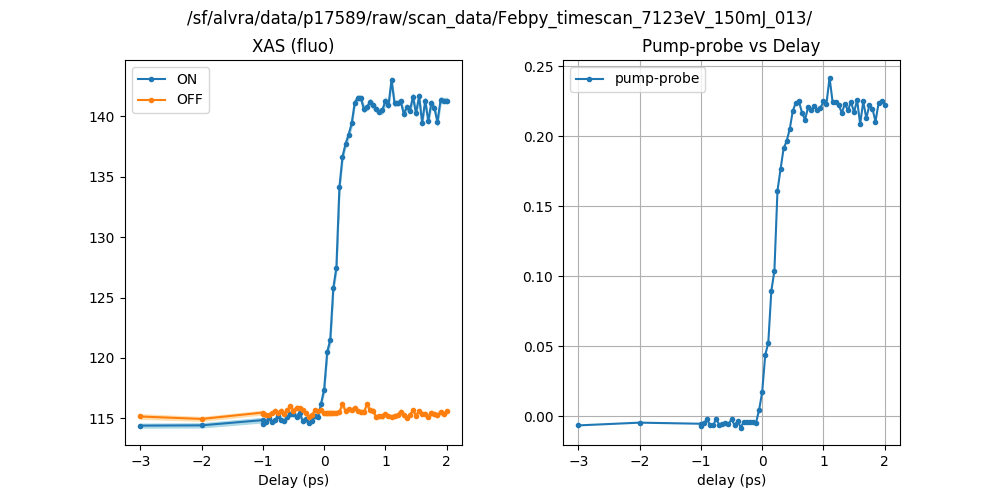

In [22]:
#Timezero = 141.36   # position of Timezero on PP delay (in mm!)
Timezero = 141.44   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !
#Delay_ps = Delay_mm
scale=1

offset_corr_DataFluo_pump = scale*DataFluo_pump - np.mean(scale*DataFluo_pump[:3])
offset_corr_DataFluo_unpump = scale*DataFluo_unpump - np.mean(scale*DataFluo_unpump[:3])
offset_corr_pump_probe = offset_corr_DataFluo_pump - offset_corr_DataFluo_unpump


plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)

#plt.title(DIR,horizontalalignment='right')
low_err_pump = DataFluo_pump - err_DataFluo_pump
high_err_pump = DataFluo_pump + err_DataFluo_pump
low_err_unpump = DataFluo_unpump - err_DataFluo_unpump
high_err_unpump = DataFluo_unpump + err_DataFluo_unpump
low_err_pumpprobe = (Pump_probe) - np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)
high_err_pumpprobe = (Pump_probe) + np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)

plt.subplot(1,2,1)
plt.plot(Delay_ps, scale*DataFluo_pump, label="ON",marker='.')
plt.plot(Delay_ps, scale*DataFluo_unpump, label="OFF",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Delay_ps, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Delay_ps, scale*(Pump_probe/DataFluo_unpump), label="pump-probe",marker='.')
#plt.fill_between(Delay_ps, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
plt.grid()
plt.xlabel("delay (ps)")
plt.gca().set_title('Pump-probe vs Delay')
plt.legend(loc="best")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

In [103]:
#Pump_probe12 = -Pump_probe.copy()
#Pump_probe13 = -Pump_probe.copy()
#Pump_probe09 = -Pump_probe.copy()
#Pump_probe08 = -Pump_probe.copy()


In [145]:
#Pump_probe_sum = Pump_probe12[1:54]  + Pump_probe13[1:54] + Pump_probe09[1:54] + Pump_probe08[1:54] 
Pump_probe_sum = Pump_probe08[1:49] 
Delay_ps_neu = Delay_ps[1:49]
Delay_ps_neu.size

48

<IPython.core.display.Javascript object>


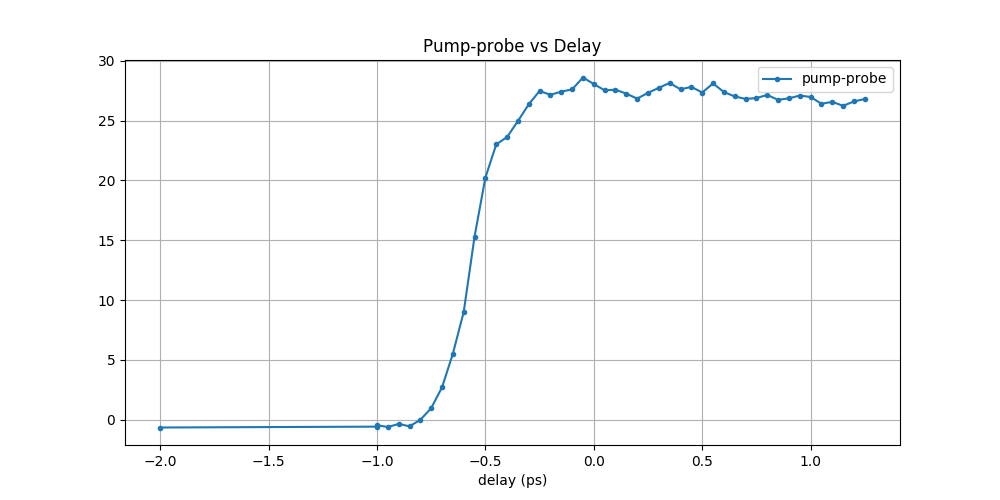

<function matplotlib.pyplot.show>

In [146]:
plt.figure(figsize = (10,5))
plt.plot
plt.plot(Delay_ps_neu, scale*(Pump_probe_sum), label="pump-probe",marker='.')
#plt.fill_between(Delay_ps, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
plt.grid()
plt.xlabel("delay (ps)")
plt.gca().set_title('Pump-probe vs Delay')
plt.legend(loc="best")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 
plt.show

## Fourier Transform

In [ ]:
# perform fft from transient 


In [148]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_ps_neu) | np.isnan(Pump_probe_sum))

parameters,extras = curve_fit(errfunc_fwhm, Delay_ps_neu[index], Pump_probe_sum[index], p0 = [95, 0.3, 0, 0.1])

print("Position t0 =",np.round(parameters[2],5),"ps")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"fs")

Position t0 = -0.56404 ps
Width = 273.0 fs


<IPython.core.display.Javascript object>


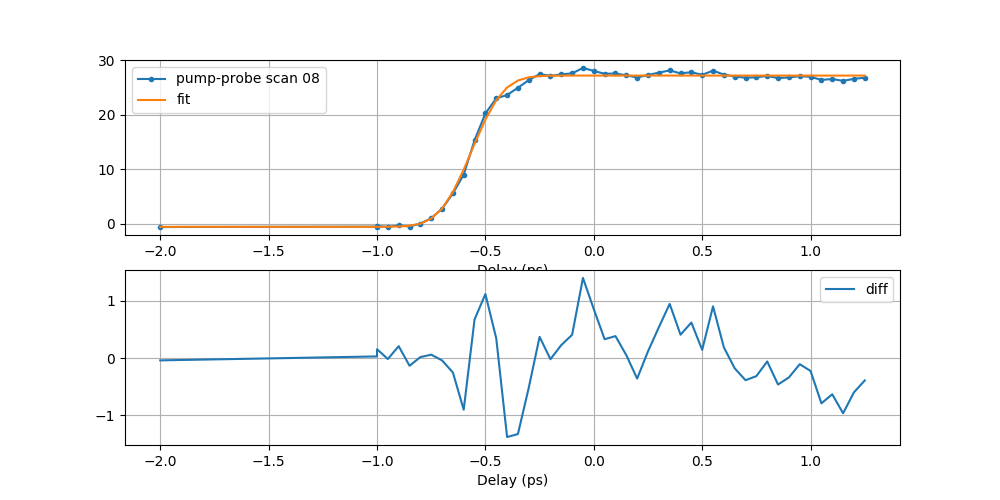

In [164]:
plt.figure(figsize = (10,5))
plt.subplot(2,1,1)
plt.plot(Delay_ps_neu, scale*(Pump_probe_sum), label="pump-probe scan 08",marker='.')
plt.plot(Delay_ps_neu, errfunc_fwhm(Delay_ps_neu,*parameters), label="fit")

plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")

plt.subplot(2,1,2)
plt.plot(Delay_ps_neu,(scale*(Pump_probe_sum)-errfunc_fwhm(Delay_ps_neu,*parameters)),label="diff")

plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")


plt.show()

Pump_probe_oszi = (scale*(Pump_probe_sum)-errfunc_fwhm(Delay_ps_neu,*parameters))


#plt.savefig(savedir + 'scan_YAG_007')

In [53]:
print(Delay_ps[4:64].size)
1/0.05

60


20.0

0.05001079910414319


<IPython.core.display.Javascript object>


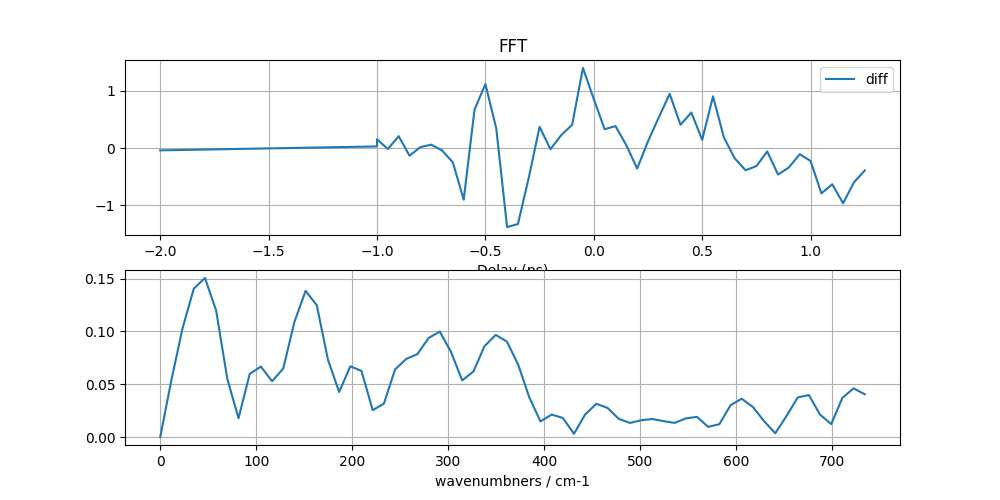

0.05001079910414319


In [198]:
#Number of sample points
NN = Delay_ps_neu[4:64].size
# sample spacing
d_time = Delay_ps_neu[6]- Delay_ps_neu[5]
print(d_time)
#T = 1/NN
x = np.linspace(0.0, N*T, N)
# Create a zero-padded version of x
y_pad = np.pad(Pump_probe_oszi, (40, 40), 'constant')
N = y_pad.size
T = 1/N


y = Pump_probe_oszi
yf = fft(y_pad)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)*1/(2*d_time*0.2998*N/NN)


plt.figure(figsize = (10,5))
plt.subplot(2,1,1)
plt.plot(Delay_ps_neu,scale*Pump_probe_oszi,label="diff")

plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")
plt.gca().set_title('FFT')
plt.subplot(2,1,2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()
#plt.xlabel("Frequency THz")
plt.xlabel("wavenumbners / cm-1")



print(d_time)

In [ ]:
#### This is to save h5 data ####

savedir = "/das/work/p17/p17589/"

h5f = h5py.File(savedir + 'Scan_14_XES_CytCFe3','w') 
#h5f = h5py.File(savedir + 'timeScan_4.h5','w')     
#h5f = h5py.File(savedir + 'RIXS_144.h5','w')

h5f.create_dataset('Delay_mm', data = Delay_mm)
#h5f.create_dataset('Energy_BS', data = Energy_eV)
h5f.create_dataset('XAS_transient', data = XAS_trans_roi1)
#h5f.create_dataset('Err_XAS_transient', data = Error_XAS_roi1)
h5f.create_dataset('RIXS_unpumped', data = RIXS_unpumped_roi1)
#h5f.create_dataset('Err_RIXS_unpumped', data = Error_unpumped_roi1)
h5f.create_dataset('RIXS_pumped', data = RIXS_pumped_roi1)
h5f.create_dataset('RIXS_transient', data = RIXS_transient_roi1)
#h5f.create_dataset('Err_RIXS_transient', data = Error_transient_roi1)

h5f.close()